This notebook measures performance of our system on the test set of 300 articles with multiple correct labels.

So this time we pefrom multilabel classification.

We test 3 different approaches:
- classification through article similarity to IPTC category name 
- classification through article similarity to IPTC category description 
- classification through article similarity to IPTC category description with keywords

In [ ]:
import autorootcwd
import os
import pandas as pd
from src.exploratory_data_analysis import gather_data
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
import openai
import matplotlib.pyplot as plt

# Benchmark

After performing the expansion of IPTC category descriptions, we compare their results with our baseline - IPTC category names embeddings.

In [2]:
def generate_predictions(df_articles, df_taxonomy, column_name_article_embedding, column_name_category_embedding):
    """Classifies articles based on the taxonomy.
    
    Args:
        df_articles (pd.DataFrame): Dataframe containing the articles.
        df_taxonomy (pd.DataFrame): Dataframe containing the taxonomy.
        
    Returns:
        pd.DataFrame: Dataframe containing the articles with the predicted categories.
    """
    
    article_embeddings = df_articles[column_name_article_embedding]
    category_embeddings = df_taxonomy[column_name_category_embedding]
    
    if isinstance(article_embeddings.iloc[0], str):
        article_embeddings = article_embeddings.apply(eval)
    
    if isinstance(category_embeddings.iloc[0], str):
        category_embeddings = category_embeddings.apply(eval)
    
    article_embeddings = np.array(article_embeddings.tolist())
    category_embeddings = np.array(category_embeddings.tolist())
    
    # compute similarity matrix of each article to each category
    similarity_scores = cosine_similarity(article_embeddings, category_embeddings)
    probabilities = similarity_scores / similarity_scores.sum(axis=1, keepdims=True)
    preds = np.argmax(probabilities, axis=1)
    preds_names = df_taxonomy['name'].iloc[preds].values
    
    # create output dataframe
    df_output = df_articles.copy()
    df_output['predicted_category_name'] = preds_names
    df_output['predicted_category_number'] = preds
    df_output['predicted_category_probability'] = np.max(probabilities, axis=1)
    df_output['predicted_categories_all_probabilities'] = [str(list(probs)) for probs in probabilities]
    
    return df_output

Load test dataset and taxonomy

In [ ]:
# read test dataset and taxonomy
df_articles_testset = pd.read_csv('labeling_app/labeled_data.csv')
print(df_articles_testset.columns)

df_taxonomy = pd.read_csv('data/taxonomy/taxonomy_expanded.csv')
print(df_articles_testset.shape, df_taxonomy.shape)

Generate embeddings for articles from test set

In [4]:
from tqdm import tqdm
tqdm.pandas()

client = openai.Client()

def get_embedding(text, model="text-embedding-ada-002"):
   response = client.embeddings.create(input = [text], model=model)
   return response.data[0].embedding

# add column 'ada_embedding' to df_articles_testset
df_articles_testset['ada_embedding'] = df_articles_testset['text'].progress_apply(get_embedding)

100%|██████████| 300/300 [03:13<00:00,  1.55it/s]


Generate predictions

In [ ]:
df_output_testset_names = generate_predictions(df_articles_testset, df_taxonomy, 'ada_embedding', 'ada_embedding_name')
print(df_output_testset_names.shape)

df_output_testset_descriptions = generate_predictions(df_articles_testset, df_taxonomy, 'ada_embedding', 'ada_embedding_description')
print(df_output_testset_descriptions.shape)

df_output_testset_expanded_descriptions = generate_predictions(df_articles_testset, df_taxonomy, 'ada_embedding', 'final_description_ada_embedding')
print(df_output_testset_expanded_descriptions.shape)

In [8]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

def dynamic_coverage_top_k_accuracy_score(y_true, y_score):
    """
    Computes dynamic coverage top-k accuracy.

    Args:
        y_true (list of list): True labels, each sublist containing multiple correct classes.
        y_score (list of list): Predicted probabilities for each class.

    Returns:
        float: Dynamic coverage top-k accuracy score.
    """
    # Flatten the list of true labels and create a binarized matrix
    mlb = MultiLabelBinarizer()
    y_true_binarized = mlb.fit_transform(y_true)

    # Calculate the dynamic coverage accuracy
    coverage_scores = []
    for i, true_labels in enumerate(y_true):
        # Determine the number of top labels to consider (equal to the number of true labels)
        top_k = len(true_labels)

        # Find the indices of the top k scores
        top_k_indices = np.argsort(y_score[i])[-top_k:]

        # Find the indices of the true labels in the binarized matrix
        true_indices = np.where(mlb.transform([true_labels])[0])[0]

        # Count how many true labels are in the top k predictions
        match_count = np.sum(np.isin(true_indices, top_k_indices))

        # Calculate the coverage for this instance
        if len(true_labels) > 0:
            coverage_scores.append(match_count / len(true_labels))
        else:
            coverage_scores.append(1.0)  # Handle case with no true labels

    # Return the average coverage
    return np.mean(coverage_scores)

## Compute metrics for results

In [ ]:
label_mapping = dict(zip(df_taxonomy['name'], list(range(len(df_taxonomy['name'])))))
true_labels_names = df_articles_testset["proposed_label"].apply(eval)

# true_labels_names are list of labels, map all elements from list for each record into id
true_labels_ids = [[label_mapping[label] for label in labels] for labels in true_labels_names]

In [11]:
predicted_label_probabilities = df_output_testset_names['predicted_categories_all_probabilities'].apply(eval).tolist()
top3_acc_names = dynamic_coverage_top_k_accuracy_score(true_labels_names, predicted_label_probabilities)
print(top3_acc_names)

0.7382222222222222


In [12]:
predicted_label_probabilities = df_output_testset_descriptions['predicted_categories_all_probabilities'].apply(eval).tolist()
top3_acc_desc = dynamic_coverage_top_k_accuracy_score(true_labels_names, predicted_label_probabilities)
print(top3_acc_desc)

0.4565555555555555


In [13]:
predicted_label_probabilities = df_output_testset_expanded_descriptions['predicted_categories_all_probabilities'].apply(eval).tolist()
top3_acc_exp_desc = dynamic_coverage_top_k_accuracy_score(true_labels_names, predicted_label_probabilities)
print(top3_acc_exp_desc)

0.6826666666666668


## Plot results

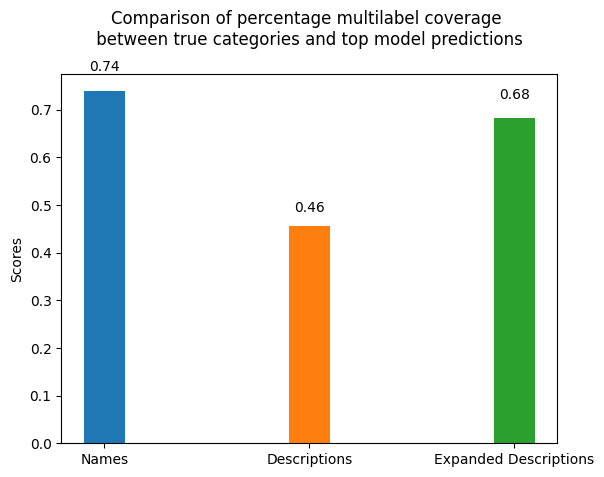

In [17]:
# Create a bar chart
x = range(3)  # three metrics
width = 0.2

fig, ax = plt.subplots()
bars1 = ax.bar(x[0], top3_acc_names, width, label='Names', align='center')
bars2 = ax.bar(x[1], top3_acc_desc, width, label='Descriptions', align='center')
bars3 = ax.bar(x[2], top3_acc_exp_desc, width, label='Expanded Descriptions', align='center')

# Function to attach a label on each bar
def autolabel(bars, score):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., 1.05 * height,
                '%.2f' % score,
                ha='center', va='bottom')

autolabel(bars1, top3_acc_names)
autolabel(bars2, top3_acc_desc)
autolabel(bars3, top3_acc_exp_desc)

# Set the labels and title
ax.set_ylabel('Scores')
ax.set_title('Comparison of percentage multilabel coverage \n between true categories and top model predictions \n')
ax.set_xticks(x)
ax.set_xticklabels(['Names', 'Descriptions', 'Expanded Descriptions'])

# Set the legend in the bottom right corner
# ax.legend(loc='lower right')

# Show the plot
plt.show()